In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from FinMind.Data import Load
TaiwanStockInfo = Load.FinData(dataset = 'TaiwanStockInfo')
data = Load.FinData(dataset = 'TaiwanStockPrice',select = '2330',date = '2018-01-01')

fig=plt.figure(figsize=(20,8))
plt.xticks(rotation = 90)  
ax1 = plt.subplot(111)
ax1.plot(data.close,color='red',label='close')
ax1.plot(data.open,color='green',label='open')
plt.legend()
# twin 為共享x軸
ax2= ax1.twinx()
plt.bar(data.date,data.Trading_Volume.astype('int')//1000)
ax3 = ax1.twinx()

data.head()

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in, n_out, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# 取Volume, open, close, max, min
data = data[['Trading_Volume','open','close','max','min']]

# MinMaxScale
from sklearn.preprocessing import MinMaxScaler 
sc = MinMaxScaler(feature_range = (0, 1))
dataset_scaled = sc.fit_transform(data)

# series to supervised
dataset_scaled_reframed = series_to_supervised(dataset_scaled, 1, 1)
dataset_scaled_reframed.drop(dataset_scaled_reframed.columns[[6,7,8,9]], axis=1, inplace=True)
print(dataset_scaled_reframed)

     var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var1(t)
1     0.085737   0.070447   0.083051   0.071307   0.084192  0.166725
2     0.166725   0.085911   0.098305   0.089983   0.099656  0.151736
3     0.151736   0.099656   0.106780   0.096774   0.103093  0.119353
4     0.119353   0.099656   0.108475   0.096774   0.108247  0.108231
5     0.108231   0.106529   0.115254   0.105263   0.116838  0.091598
..         ...        ...        ...        ...        ...       ...
710   0.187435   0.950172   0.952542   0.952462   0.962199  0.864459
711   0.864459   0.969072   0.923729   0.957555   0.941581  0.206091
712   0.206091   0.957045   0.955932   0.945671   0.951890  0.335822
713   0.335822   0.991409   0.986441   0.979626   0.986254  0.197656
714   0.197656   0.991409   0.979661   0.977929   0.991409  0.284949

[714 rows x 6 columns]


In [ ]:
dataset_scaled_reframed = dataset_scaled_reframed.values
# train, test split
train_size = int(len(dataset_scaled_reframed) * 0.7)
test_size = len(dataset_scaled_reframed) - train_size
train, test = dataset_scaled_reframed[0:train_size, :], dataset_scaled_reframed[train_size:len(dataset_scaled_reframed), :]

print('Training size: ', train_size)
print('Test size: ', test_size)

# split into input and outputs
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]

# reshape into [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print('training_shape: ',X_train.shape, y_train.shape)
print('testing_shape: ',X_test.shape, y_test.shape)

Training size:  499
Test size:  215
training_shape:  (499, 1, 5) (499,)
testing_shape:  (215, 1, 5) (215,)


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

model = Sequential()
model.add(SimpleRNN(units = 100, input_shape = (X_train.shape[1],X_train.shape[2])))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model.fit(X_train, y_train, epochs = 100, batch_size = 10)
plt.title('train_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.plot(history.history["loss"])

In [ ]:
predicted_stock_price = model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))

# invert scaling for forecast
inv_yhat = np.concatenate((predicted_stock_price, X_test[:, 1:]), axis=1)
inv_yhat = sc.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y = np.concatenate((y_test, X_test[:, 1:]), axis=1)
inv_y = sc.inverse_transform(inv_y)
inv_y = inv_y[:,0]

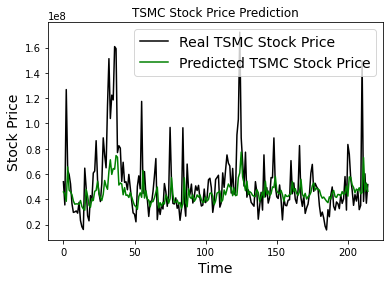

In [ ]:
# Plot prediction vs Real
plt.plot(inv_y, color = 'black', label = 'Real TSMC Stock Price')
plt.plot(inv_yhat, color = 'green', label = 'Predicted TSMC Stock Price')
plt.title('TSMC Stock Price Prediction')
plt.xlabel('Time',size=14)
plt.ylabel('Stock Price',size=14)
plt.legend(fontsize=14)
plt.show()